In [1]:
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import mplfinance as mpf
import yfinance as yf
from talib import abstract
# add base to the modules
from indicators import indicators as ind
from indicators import normalize as nor
from matplotlib import pyplot as plt
import math
import pathlib
from typing import Dict, List, Tuple, Union
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

plt.style.use('dark_background')
%matplotlib inline

### load ticker function

In [2]:
def load_ticker(sym, period="5y", interval="1d"):
    return yf.Ticker(sym).history(period, interval).reset_index()


In [3]:
def load_tickers(symbols: list, period="5y", interval="1d") -> Dict[str, pd.DataFrame]:
    frames: Dict[str, pd.DataFrame] = {}
    for sym in symbols:
        frames[sym] = load_ticker(sym, period, interval)
    return frames

In [4]:
def plot_tickers(frames: Dict[str, pd.DataFrame], figsize=(18,6)):
    for symbol, df in frames.items():
        plt.figure(figsize=figsize)
        df["Close"].plot(title=f"{symbol} Close")
    plt.show()

In [5]:
tickers = load_tickers(['SPY', 'QQQ'])

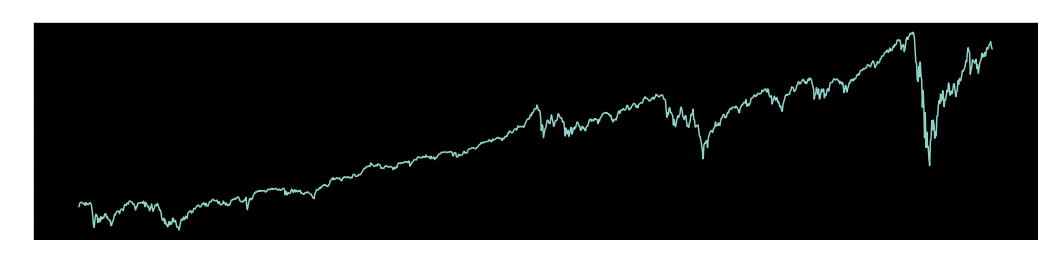

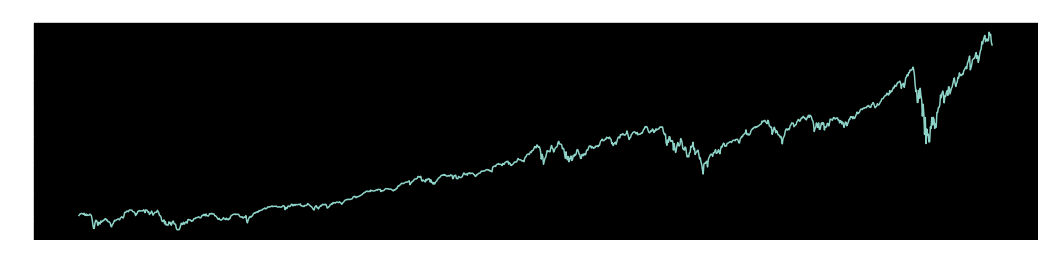

In [6]:
plot_tickers(tickers, (18,4))

In [7]:
def add_indicators(df: pd.DataFrame) -> Tuple[Dict[str, List[ind.Indicator]], pd.DataFrame]:

    indicators = {
        'CNDL': [],  # candle patterns
        'PRICE': [], # price relative indicators
        'BOOL': [],  # boolean indicators (1,0)
        'MACD': [],
        'ADX': [],
        'EOM': [],
        'PFC': [],  # the target for the nn

    }
    # set the mid price
    mid = ind.Mid()
    indicators['Mid'] = [mid]
    df = mid.concat(df, df['Open'], df['Close'])

    # numpy-ize
    o = df['Open'].to_numpy()
    h = df['High'].to_numpy()
    l = df['Low'].to_numpy()
    c = df['Close'].to_numpy()
    m = df['Mid'].to_numpy()

    # add candles patterns
    i_cndl = ind.CNDL()
    indicators['CNDL'] = [i_cndl]
    df = i_cndl.concat(df, o, h, l, c)

    for i in [3,5,8,13,21,34,55,89]:
        # EMA
        i_ema = ind.EMA(i)
        indicators['PRICE'].append(i_ema)
        df = i_ema.concat(df, m)
        # SMA
        i_sma = ind.SMA(i)
        indicators['PRICE'].append(i_sma)
        df = i_sma.concat(df, m)
        # triple EMA
        i_tema = ind.TEMA(i)
        indicators['PRICE'].append(i_tema)
        df = i_tema.concat(df, m)
        # comparison


    indicators['BOOL'] = []
    for i in [13,21,34,55]:
        # BBANDS
        i_bb2 = ind.BBANDS(i)
        i_bb3 = ind.BBANDS(i)
        indicators['PRICE'].append(i_bb2)
        indicators['PRICE'].append(i_bb3)
        df = i_bb2.concat(df, c)
        # KEL
        i_kel = ind.KelCh(i)
        indicators['PRICE'].append(i_kel)
        df = i_kel(df, c)
        # squeeze
        i_sqz = ind.Squeeze(i, 2, 2)
        indicators['BOOL'].append(i_sqz)
        df = i_sqz(df, c)


    indicators['SAR'] = []
    for i in [.2,.3,.5,.8]:
        i_sar = ind.SAR(i, 1.)
        indicators['SAR'].append(i_sar)
        df = i_sar.concat(df, h, l)

    return indicators, df

In [8]:
inds, tickers['SPY'] = add_indicators(tickers['SPY'])

In [9]:
print(tickers['SPY'])

      SAR a=0.8, m=1.0  SAR a=0.5, m=1.0  SAR a=0.3, m=1.0  SAR a=0.2, m=1.0  \
0                  NaN               NaN               NaN               NaN   
1              187.900            187.90         187.90000         187.90000   
2              187.356            187.56         187.69600         187.76400   
3              189.500            189.50         188.77840         188.45840   
4              189.600            189.60         189.51784         189.14336   
...                ...               ...               ...               ...   
1254           319.740            319.74         319.74000         319.74000   
1255           320.620            320.62         320.62000         320.62000   
1256           323.940            323.94         323.94000         323.94000   
1257           324.500            324.50         324.50000         324.50000   
1258           324.500            324.50         324.50000         324.50000   

        SMA p=89    EMA p=89    SMA p=5